# Compare and Group Time Series

Cluster Time Series Experiment

1. motivation: grouping data when doing analysis of a data set has analogy to the concepts of regularization and generalization in supervised machine learning setting in addition to helping the analyst better understand and give explanation to the data. 

2. technique: a common way to divide a set of objects into smaller groups is clustering. (Ward 1963) argued that grouping is useful for analysis of data with many samples and how partitioning the set of objects into smaller groups can yield more information. His illustrating example was that using single statistical mean value of the whole set of objects provided less useful information than having several statistical mean values of each group.

3. question: to build clustering model for stock grouping problem using unsupervised learning. between two linkage methods (single and average) which is better? between two disimilarity measure (dynamic time warping and correlation distance) which is better?

4. hypothesis: time-series objects, in this context stock prices and asset returns, in the same group have similar behavior and their movement can be forecasted the same way.

Hierarchical agglomerative clustering is a procedure to cluster data into group by starting with each data item as its own cluster can sequentially merge similar item into clusters until one cluster containing the whole data set is formed. (Mullner 2013) documented three efficient algorithms for performing hierarchical agglomerative clustering, and noted the seven linkage schemes that can be used in the procedure: single, complete, average, weighted, Ward, centroid, median. The input of clustering procedure is dissimilar index, which measure distance-like quantity between each pair of objects in the data set. The output of clustering procedure is stepwise dendrogram, which indicate at which iteration two items are merged and what distance measurement was at the merge.

## 1. Time Series Data

Data recorded at different times form a set of observations that is a time-series. Time-series data are sequence of obervations. Price of stocks realized over a time period can be modelled as a time-series, as with many other phenomenon.

When there are several sequences, we view each as individual sequence as an object and all sequences as the set of objects.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from data.simulation import dgf10, dgf11, plot_line, gd2df, add_noise, TimeSeries

from data.simulation import make_dataset_linear, make_dataset_exponential
from data.generator import make_gbm_series

ModuleNotFoundError: No module named 'data'

### Data Set 1: Linear vs Exponential

In [ ]:
dataset = {} # to store dataset
dataset, df_stat_linear = make_dataset_linear(dataset, plot=False)
dataset, df_stat_growth = make_dataset_exponential(dataset, plot=False)

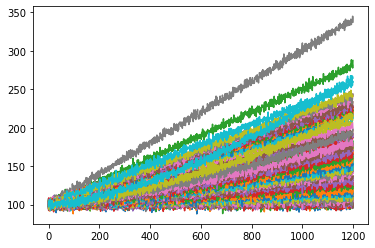

In [3]:
for k, v in dataset.items():
    data = v[1][['y']].values # get y from data frame
    plt.plot(data)

### Geometric Brownian Motion

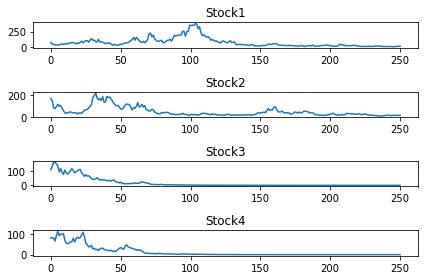

In [4]:
dataset2 = {} # storing data

fix, axes42 = plt.subplots(4,1)

p = range(1,5)
name = ['Stock1', 'Stock2', 'Stock3', 'Stock4']
s0 = [100, 150, 100, 100] # start prices
mu = [0.00005, None, None, -0.0002]
sigma = [0.2, None, None, 0.1]

for i, name, s0, mu, sigma, axes in zip(p, name, s0, mu, sigma, axes42):
    t, S = make_gbm_series(s0, mu=0.00005, sigma=0.2)
    plt.subplot(4,1,i)
    plt.plot(t,S)
    plt.setp(plt.gca(), title=name)
    dataset2[name] = (t,S)
    
plt.tight_layout()
plt.show()

### Historical Stock

Text(0.5, 1.08, 'Price')

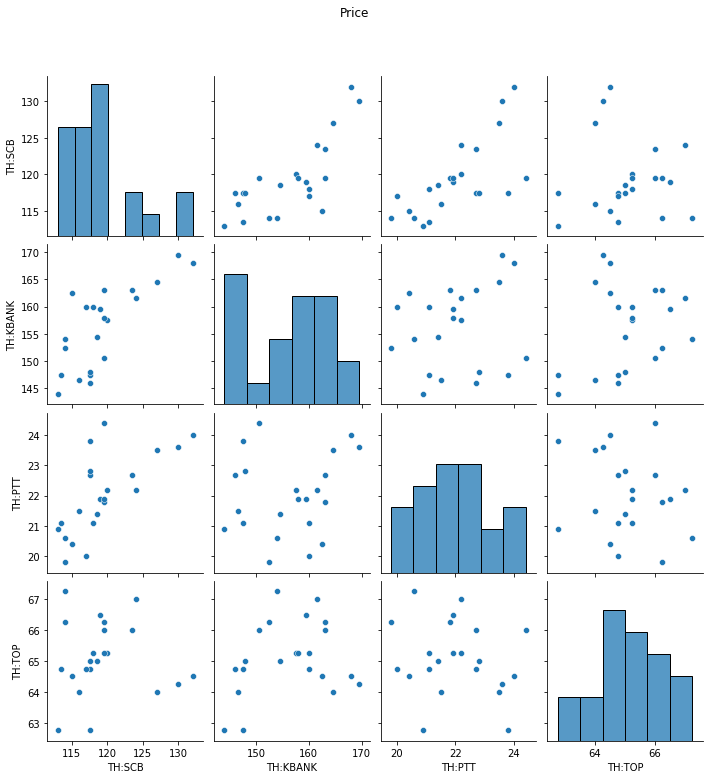

In [5]:
from dataset import get_dataset_db

db_engine = get_dataset_db()
# Select by date
sql = """SELECT f.date, f.stock, f.P FROM set100_daily_fact f
WHERE f.date BETWEEN '2015-01-01' AND '2019-12-31'
AND f.stock IN ('TH:SCB','TH:KBANK','TH:PTT','TH:TOP')
;"""
df_fact = pd.read_sql(sql, db_engine)
# df_fact

stocks = ('TH:SCB','TH:KBANK','TH:PTT','TH:TOP')

series = []
for s in stocks:
    s1 = df_fact[df_fact['stock']==s][['date','P']]
    s1 = s1.set_index('date').rename(columns={'P':s})
    series.append(s1)
df = pd.concat(series, axis=1)
df

dataset3 = df.copy() # dataset of stock

g = sns.pairplot(df)
g.fig.suptitle("Price", y=1.08) # y= some height>1

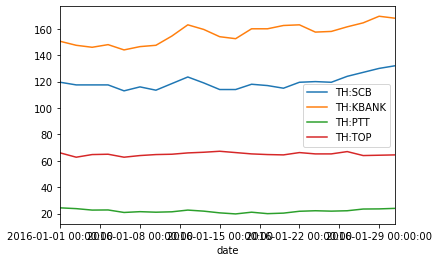

In [6]:
df.plot()

## 2. Dissimilarity Index

Each time series is consider an individual sequence object. To compare between two objects, distance-like quantity is calculated.


Distance matrix or dissimiarily index is the input to hierarchical clustering algorithm. To learn from data, algorithm sort and group objects using these values for comparison. 

For a set of N object, there is N choose 2 index values.

For a set of three sequences, there are 3 distance measures.

| N | distance measures |
|---| --- |
| 2 | 1 |
| 3 | 3 |
| 4 | 6 |
| 5 | 10 |


Distance correlation

https://en.wikipedia.org/wiki/Distance_correlation



To demonstrate the concept of similarity, consider an example case that compare three sequences using Euclidean distance measure versus Dynamic Time Warping distance measure.

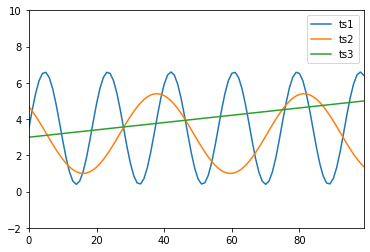

In [7]:
# Example by Minnar2014 
#  https://nbviewer.jupyter.org/github/alexminnaar/time-series-classification-and-clustering/blob/master/Time%20Series%20Classification%20and%20Clustering.ipynb

x=np.linspace(0,50,100)
ts1=pd.Series(3.1*np.sin(x/1.5)+3.5)
ts2=pd.Series(2.2*np.sin(x/3.5+2.4)+3.2)
ts3=pd.Series(0.04*x+3.0)

ts1.plot()
ts2.plot()
ts3.plot()

plt.ylim(-2,10)
plt.legend(['ts1','ts2','ts3'])
plt.show()

dataset4 = {'sine1': ts1, 'sine2': ts2, 'line1': ts3}

In this example, intuitively ts1 and ts2, the two sine waves, should be more similar than ts1 and ts3, the first sine wave and the green line.

In [8]:
from scipy.spatial.distance import correlation, cosine


# hemming
# cityblock

# https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.spatial.distance.cosine.html#scipy.spatial.distance.cosine
# https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.spatial.distance.correlation.html

In [9]:
from scipy.spatial.distance import euclidean, correlation, cosine, euclidean, cityblock
from fastdtw import fastdtw
ts1ts2 = euclidean(ts1,ts2)
ts1ts2 = fastdtw(ts1,ts2)
ts1ts3 = euclidean(ts1,ts3)
ts1ts3 = fastdtw(ts1,ts3)


res = {'base': ['ts1','ts1', 'ts2'], 'target': ['ts2','ts3', 'ts3'], 
       'distance (Euclidean)': [euclidean(ts1,ts2),euclidean(ts1,ts3),euclidean(ts2,ts3)],
       'distance (Cosine)': [cosine(ts1,ts2),cosine(ts1,ts3),cosine(ts2,ts3)],
       'distance (Cityblock)': [cityblock(ts1,ts2),cityblock(ts1,ts3),cityblock(ts2,ts3)], 
       'distance (Correlation)': [correlation(ts1,ts2),correlation(ts1,ts3),correlation(ts2,ts3)], 
       'distance (Dynamic Time Warping)': [fastdtw(ts1,ts2)[0], fastdtw(ts1,ts3)[0], fastdtw(ts2,ts3)[0]]}
pd.DataFrame(data=res)

,base,target,distance (Euclidean),distance (Cosine),distance (Cityblock),distance (Correlation),distance (Dynamic Time Warping)
0,ts1,ts2,26.959216,0.225398,222.758020,0.994562,144.758154
1,ts1,ts3,23.189249,0.155317,203.927876,1.031536,206.595393
2,ts2,ts3,17.298735,0.095468,144.778829,0.830631,129.126684


Using Euclidean distance as metric, time series ts2 and ts3 appears more similar than ts1 and ts2 which is counter intuitive. Whereas Dynamic Time Warping distance and correlation distance meaures produce the expected outcome.

The second sine wave and the line, ts2 and ts3, appear to be the most similar from all measures probably because the amplitude of the sine wave covers the line segment entirely.

### Linear vs Exponential

In [10]:
keys = list(dataset.keys())
ts1 = dataset[keys[0]][1]['y']
ts2 = dataset[keys[1]][1]['y']
ts3 = dataset[keys[2]][1]['y']

In [11]:
# keys

In [12]:
euclidean(ts1,ts2) # use Euclidean distance to measure dissimilarity.

282.5483514549967

In [13]:
from math import sqrt
def euclid_dist(t1,t2):
    return sqrt(sum((t1-t2)**2))
euclid_dist(ts1,ts2) # manual implementation of euclidean distance calculation for 1-D array.

282.5483514549966

In [14]:
# use FastDTW (approximation of DTW) to measure dissimarity
fastdtw(ts1,ts2)[0]

6821.520618131643

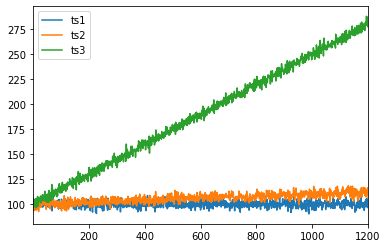

In [15]:
ts1.plot(legend=True, label='ts1')
ts2.plot(legend=True, label='ts2')
ts3.plot(legend=True, label='ts3')

In [16]:
res = {'base': ['ts1','ts1', 'ts2'], 'target': ['ts2','ts3', 'ts3'], 
       'distance (Euclidean)': [euclidean(ts1,ts2),euclidean(ts1,ts3),euclidean(ts2,ts3)],
       'distance (Cosine)': [cosine(ts1,ts2),cosine(ts1,ts3),cosine(ts2,ts3)],
       'distance (Cityblock)': [cityblock(ts1,ts2),cityblock(ts1,ts3),cityblock(ts2,ts3)], 
       'distance (Correlation)': [correlation(ts1,ts2),correlation(ts1,ts3),correlation(ts2,ts3)], 
       'distance (Dynamic Time Warping)': [fastdtw(ts1,ts2)[0], fastdtw(ts1,ts3)[0], fastdtw(ts2,ts3)[0]]}
pd.DataFrame(data=res)

,base,target,distance (Euclidean),distance (Cosine),distance (Cityblock),distance (Correlation),distance (Dynamic Time Warping)
0,ts1,ts2,282.548351,0.001374,8110.716718,1.001239,6821.520618
1,ts1,ts3,3607.401976,0.036137,108146.770814,1.011064,107295.146651
2,ts2,ts3,3364.985246,0.027851,100878.298319,0.236208,89892.873987


Dynamic Time Warping distance indicate that ts1 and ts2 are the most similar. As with other distance measure except for correlation distance.

### Dataset: Four Stocks GBM

In [40]:
labels = list(dataset2.keys())

labels

['Stock1', 'Stock2', 'Stock3', 'Stock4']

Text(0.5, 1.0, 'four GBM series')

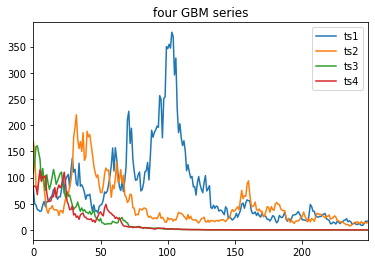

In [41]:
ts1 = dataset2['Stock1'][1] # Price values
ts2 = dataset2['Stock2'][1]
ts3 = dataset2['Stock3'][1]
ts4 = dataset2['Stock4'][1]

ts1.shape # (250,)

pd.Series(ts1).plot(legend=True, label='ts1')
pd.Series(ts2).plot(legend=True, label='ts2')
pd.Series(ts3).plot(legend=True, label='ts3')
pd.Series(ts4).plot(legend=True, label='ts4')
plt.title('four GBM series')

In [44]:
# combination in Python. n choose 2
from itertools import combinations
dist_list = list(combinations(labels, 2))

In [59]:
dcalc = pd.DataFrame()

dfuncs = {'distance (Euclidean)': euclidean, 'distance (Cosine)':cosine, 
          'distance (Correlation)':correlation, 'distance (Cityblock)': cityblock}

for c in dist_list:
    row = {}
    base,target = c[0], c[1]
    row['base'] = base
    row['target'] = target
    s1 = dataset2[base][1] # check the data query here. make it explicit. Remove the 1.
    s2 = dataset2[target][1]
    for n, f in dfuncs.items():
        row[n] = f(s1,s2)
    row['distance (Dynamic Time Warping)'] = fastdtw(s1, s2)[0]
    
    dcalc = dcalc.append(row, ignore_index=True)
dcalc

,base,distance (Cityblock),distance (Correlation),distance (Cosine),distance (Dynamic Time Warping),distance (Euclidean),target
0,Stock1,13424.617745,0.980245,0.457460,4600.621071,1395.675129,Stock2
1,Stock1,16915.574348,1.022740,0.697425,7841.523466,1579.982663,Stock3
2,Stock1,16434.224918,1.004665,0.667759,7077.482313,1563.790294,Stock4
3,Stock2,10091.508862,0.565193,0.409630,4454.007321,820.983547,Stock3
4,Stock2,9781.104509,0.559806,0.391153,3779.515994,821.628587,Stock4
5,Stock3,1458.434263,0.074988,0.059771,913.374700,216.105254,Stock4


### Dataset: Four Stocks historical

In [63]:
dataset3.tail()

,TH:SCB,TH:KBANK,TH:PTT,TH:TOP
date,,,,
2016-01-26 00:00:00,119.5,158.0,21.9,65.25
2016-01-27 00:00:00,124.0,161.5,22.2,67.00
2016-01-28 00:00:00,127.0,164.5,23.5,64.00
2016-01-29 00:00:00,130.0,169.5,23.6,64.25
2016-02-01 00:00:00,132.0,168.0,24.0,64.50


In [64]:
dataset3.values.shape

(22, 4)

In [70]:
labels = list(dataset3.columns)
labels

['TH:SCB', 'TH:KBANK', 'TH:PTT', 'TH:TOP']

In [71]:
dataset3.values[:,0] # SCB

array([119.5, 117.5, 117.5, 117.5, 113. , 116. , 113.5, 118.5, 123.5,
       119. , 114. , 114. , 118. , 117. , 115. , 119.5, 120. , 119.5,
       124. , 127. , 130. , 132. ])

Text(0.5, 1.0, 'four GBM series')

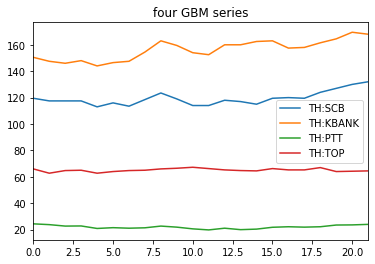

In [72]:
ts1 = dataset3.values[:,0] # Price values
ts2 = dataset3.values[:,1]
ts3 = dataset3.values[:,2]
ts4 = dataset3.values[:,3]


pd.Series(ts1).plot(legend=True, label=labels[0])
pd.Series(ts2).plot(legend=True, label=labels[1])
pd.Series(ts3).plot(legend=True, label=labels[2])
pd.Series(ts4).plot(legend=True, label=labels[3])
plt.title('four historical series')

In [73]:
# combination in Python. n choose 2
from itertools import combinations
dist_list = list(combinations(labels, 2))

In [77]:
labels.index('TH:SCB')

0

In [80]:
dcalc = pd.DataFrame()

dfuncs = {'distance (Euclidean)': euclidean, 'distance (Cosine)':cosine, 
          'distance (Correlation)':correlation, 'distance (Cityblock)': cityblock}

for c in dist_list:
    row = {}
    base,target = c[0], c[1]
    row['base'] = base
    row['target'] = target
    s1 = dataset3.values[:,labels.index(base)] # check the data query here. make it explicit. Remove the 1.
    s2 = dataset3.values[:,labels.index(target)]
    for n, f in dfuncs.items():
        row[n] = f(s1,s2)
    row['distance (Dynamic Time Warping)'] = fastdtw(s1, s2)[0]
    
    dcalc = dcalc.append(row, ignore_index=True)
dcalc

,base,distance (Cityblock),distance (Correlation),distance (Cosine),distance (Dynamic Time Warping),distance (Euclidean),target
0,TH:SCB,812.5,0.253259,0.000518,812.5,174.780577,TH:KBANK
1,TH:SCB,2141.2,0.303901,0.000877,2141.2,456.933277,TH:PTT
2,TH:SCB,1193.5,1.008240,0.001045,1193.5,255.599296,TH:TOP
3,TH:KBANK,2953.7,0.829681,0.002352,2953.7,630.662644,TH:PTT
4,TH:KBANK,2006.0,0.734965,0.001059,2006.0,429.009615,TH:TOP
5,TH:PTT,947.7,1.195941,0.002065,947.7,202.245939,TH:TOP


## 3. Linkage

In [19]:
from algorithm.clustering import dendrogram_extra
from scipy.cluster.hierarchy import dendrogram
from scipy.spatial.distance import pdist
from fastcluster import linkage
from scipy.cluster.hierarchy import linkage as linkage_scipy

labels = list(dataset4.keys())
X = [v for i, v in dataset4.items()]

In [20]:
Z = linkage(X, method='single', metric='euclidean', preserve_input=True)
Z  # Linkage matrix

array([[ 1.        ,  2.        , 17.29873509,  2.        ],
       [ 0.        ,  3.        , 23.18924919,  3.        ]])

In [21]:
Z[0] # 1st iteration:  merge   ts1 and ts2

array([ 1.        ,  2.        , 17.29873509,  2.        ])

In [22]:
Z[1] # 2nd iteration:  merge   {ts1, ts2} and ts3

array([ 0.        ,  3.        , 23.18924919,  3.        ])

In [23]:
Z = linkage_scipy(X, method='single', metric='euclidean') # scipy
Z  # Linkage matrix

array([[ 1.        ,  2.        , 17.29873509,  2.        ],
       [ 0.        ,  3.        , 23.18924919,  3.        ]])

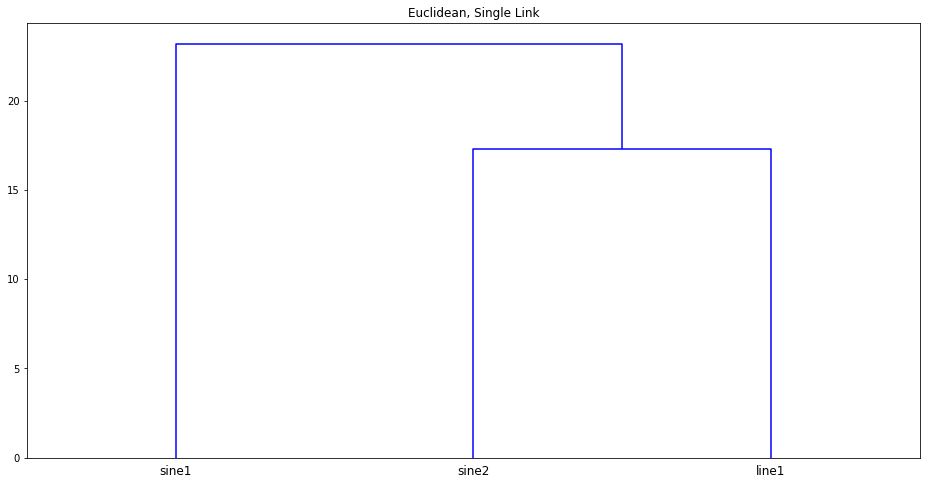

In [24]:
fig = plt.figure(figsize=(8, 4))
plt.title('Euclidean, Single Link')
dn = dendrogram(Z, labels=labels)

In [25]:
# Use DTW distance:

dm = pdist(X, lambda u, v: fastdtw(u,v)[0])
dm # get DTW distance matrix. Dissimarity index. Use squareform to get matrix form.

array([144.75815353, 206.59539301, 129.12668397])

In [26]:
Z = linkage(dm, method='single')
Z

array([[  1.        ,   2.        , 129.12668397,   2.        ],
       [  0.        ,   3.        , 144.75815353,   3.        ]])

Text(0.5, 1.0, 'DTW, Single Linkage')

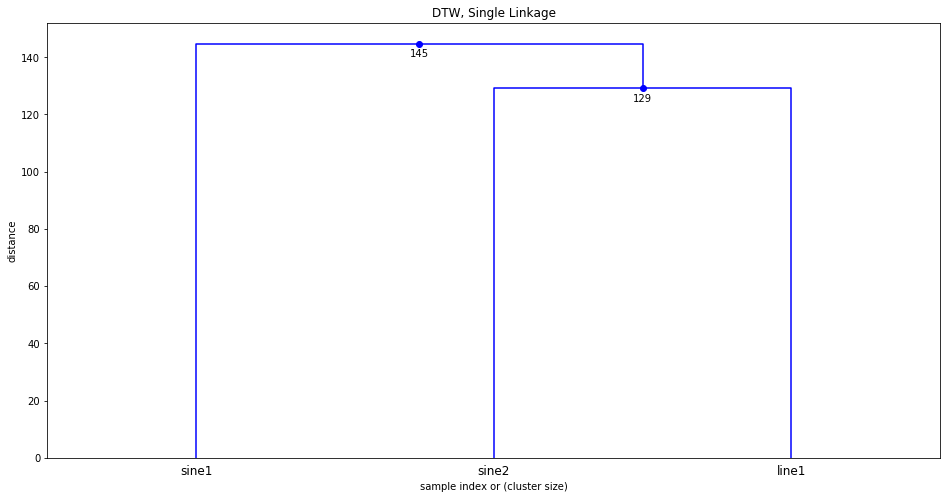

In [27]:
fig = plt.figure(figsize=(8, 4))
dn = dendrogram_extra(Z, labels=labels)
plt.title('DTW, Single Linkage')

In [28]:
Z = linkage(dm, method='average')
Z

array([[  1.        ,   2.        , 129.12668397,   2.        ],
       [  0.        ,   3.        , 175.67677327,   3.        ]])

Text(0.5, 1.0, 'DTW distance, Average Linkage')

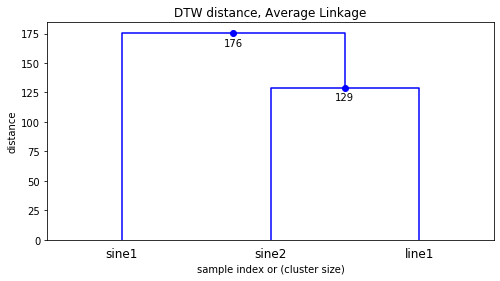

In [29]:
fig = plt.figure(figsize=(8, 4))
dn = dendrogram_extra(Z, labels=labels)
plt.title('DTW distance, Average Linkage')

#### Dataset: Linear vs Exponential

In [30]:
labels = list(dataset.keys())
X = [v[1]['y'] for i, v in dataset.items()]

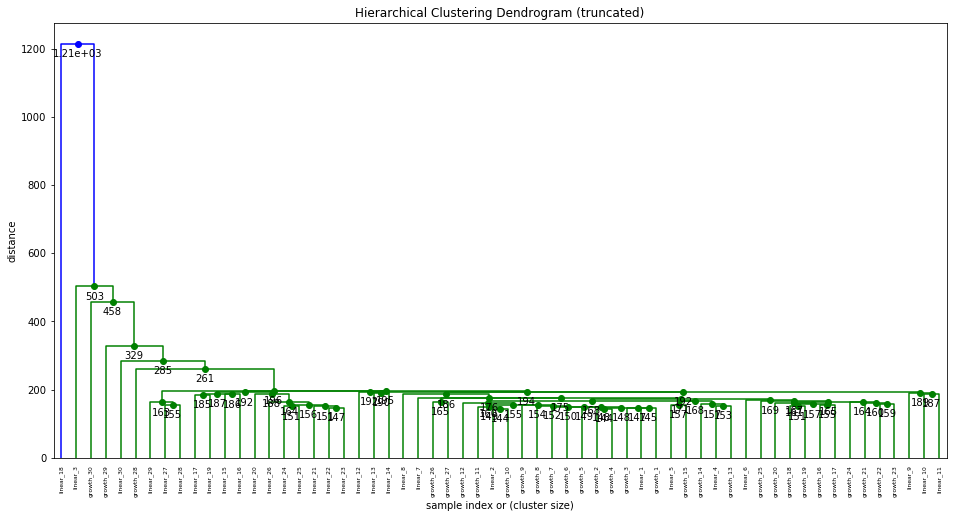

In [31]:
# Euclidean distance, single linkage
fig = plt.figure(figsize=(16, 8))
Z = linkage(X, method='single', metric='euclidean', preserve_input=True)
dn = dendrogram_extra(Z, labels=labels)

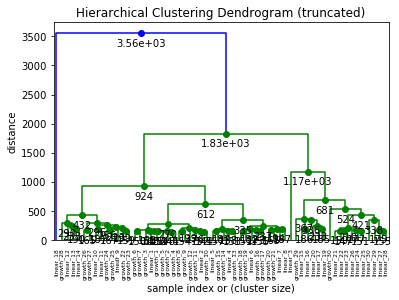

In [32]:
# Euclidean distance, average linkage

fig = plt.figure(figsize=(16, 8))
Z = linkage(X, method='average', metric='euclidean', preserve_input=True)
dn = dendrogram_extra(Z, labels=labels)

In [33]:
dm = pdist(X, lambda u, v: fastdtw(u,v)[0])
dm # get DTW distance matrix. Dissimarity index. Use squareform to get matrix form.

array([  6821.52061813, 107295.14665063,  13981.41490576, ...,
         3696.86581257,  13502.69458947,   7607.24482652])

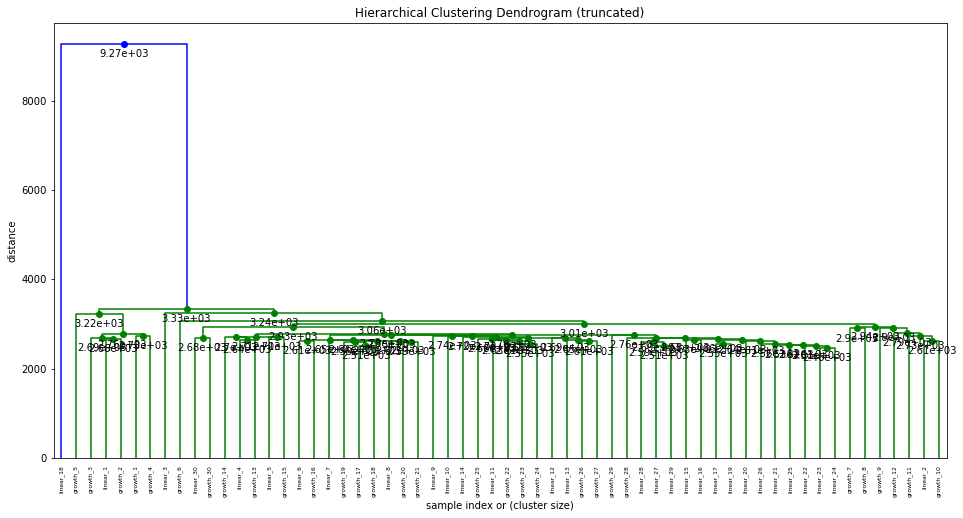

In [34]:
# DTW distance, single linkage

fig = plt.figure(figsize=(16, 8))
Z = linkage(dm, method='single')
dn = dendrogram_extra(Z, labels=labels)

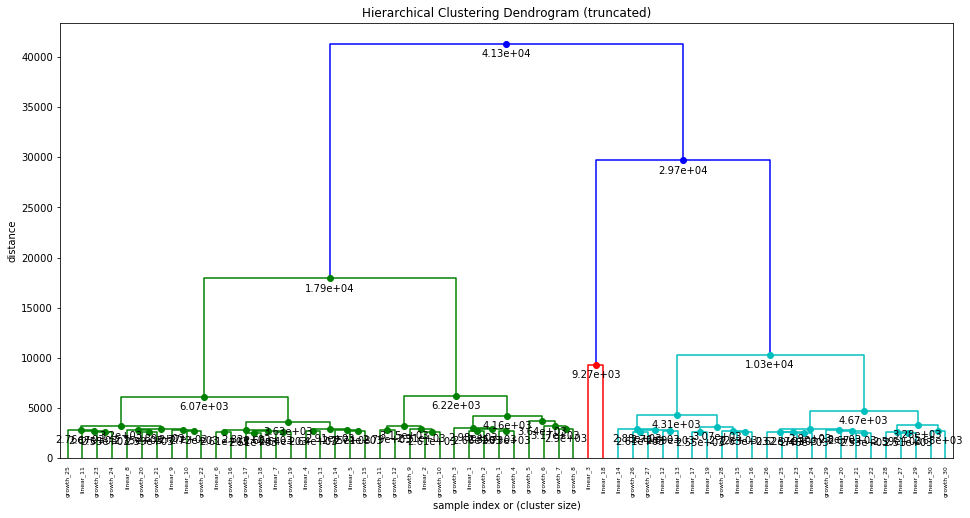

In [35]:
# DTW distance, average linkage

fig = plt.figure(figsize=(16, 8))
Z = linkage(dm, method='average')
dn = dendrogram_extra(Z, labels=labels)

Dataset: Four Stock

# 4. Cut

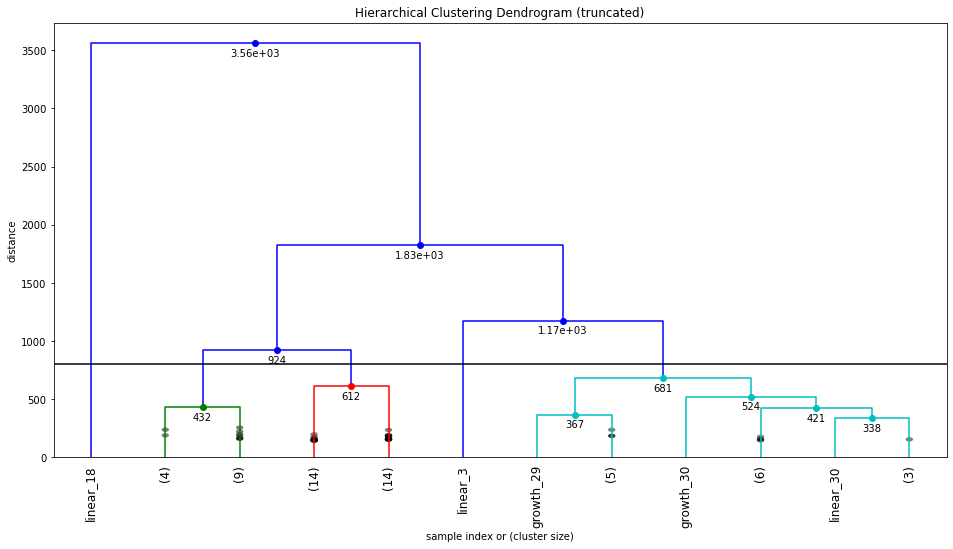

In [82]:
labels = list(dataset.keys())
X = [v[1]['y'] for i, v in dataset.items()]
# Euclidean distance, average linkage


# set cut-off to 50
max_d = 800  # max_d as in max_distance

fig = plt.figure(figsize=(16, 8))
Z = linkage(X, method='average', metric='euclidean', preserve_input=True)
dn = dendrogram_extra(Z,
                      truncate_mode='lastp',
                        p=12,
                        leaf_rotation=90.,
                        leaf_font_size=12.,
                        show_contracted=True,
                        annotate_above=10,
                        max_d=max_d,  # plot a horizontal cut-off line
                      labels=labels)

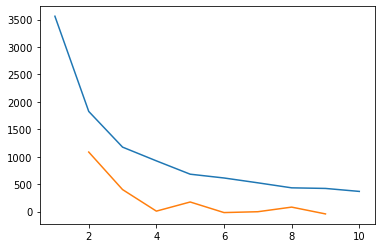

clusters: 2


In [83]:

last = Z[-10:, 2]  # check last 10 iteration in linkage matrix.
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.show()
k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print("clusters:", k)

#### Retrieve the Clusters

Knowing max_d

In [87]:
from scipy.cluster.hierarchy import fcluster
max_d = 800
clusters = fcluster(Z, max_d, criterion='distance')  ### Probably use this.
clusters

array([2, 2, 4, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 3, 3, 3, 5, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 3, 3], dtype=int32)

Knowing k


In [88]:
k=2
fcluster(Z, k, criterion='maxclust')

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

Inconsistency

In [86]:
from scipy.cluster.hierarchy import fcluster
fcluster(Z, 8, depth=10)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

# 5. Visualize

In [136]:
# X[3] # third series

# labels # ['linear_1', 'linear_2', 'linear_3', ...

In [137]:
# X[3]
# clusters[3] # label and color map

In [138]:
st_devs = list(map(np.std, X))  # Standard deviation is X-axis
means = list(map(lambda ts: np.mean(ts), X)) # Mean is Y-axis

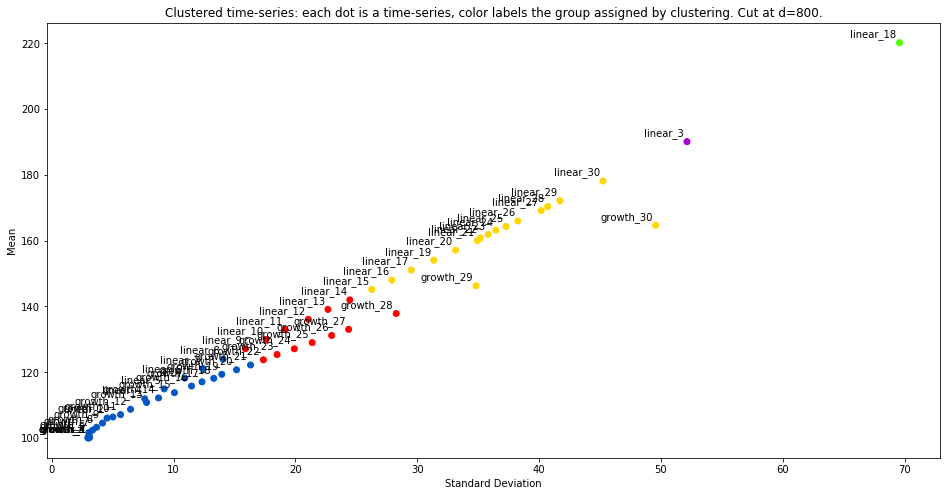

In [144]:
plt.figure(figsize=(16, 8))
plt.scatter(st_devs, means, c=clusters, cmap='prism')  # plot points with cluster dependent colors
plt.title("Clustered time-series: each dot is a time-series, color labels the group assigned by clustering. Cut at d=800.")
plt.xlabel("Standard Deviation")
plt.ylabel("Mean")

# Add label:
for label, x, y in zip(labels, st_devs, means):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-3, 3),
        textcoords='offset points', ha='right', va='bottom')

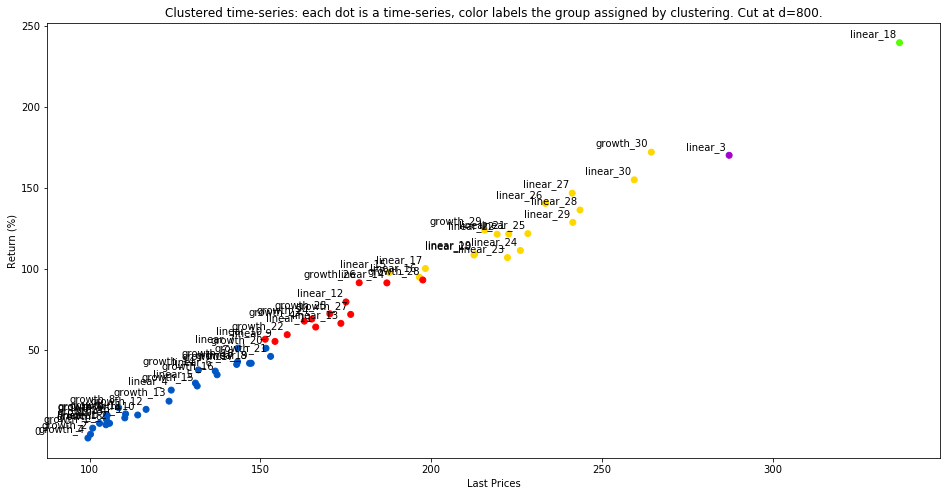

In [172]:
# plot with first value and last value 

# X[0] # this is pd.Series object

firsts = np.array(list(map(lambda ts: ts.values[0], X)))  # Standard deviation is X-axis
lasts = np.array(list(map(lambda ts: ts.values[-1], X))) # Mean is Y-axis

returns = (lasts - firsts) / firsts * 100 # Returns in pct

plt.figure(figsize=(16, 8))
plt.scatter(lasts, returns, c=clusters, cmap='prism')  # plot points with cluster dependent colors
plt.title("Clustered time-series: each dot is a time-series, color labels the group assigned by clustering. Cut at d=800.")
plt.xlabel("Last Prices")
plt.ylabel("Return (%)")

# Add label:
for label, x, y in zip(labels, lasts, returns):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-3, 3),
        textcoords='offset points', ha='right', va='bottom')

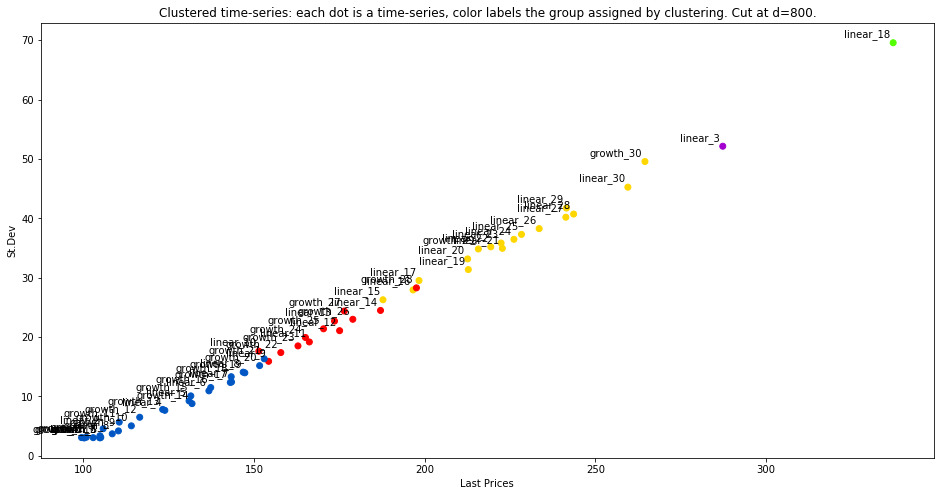

In [175]:
plt.figure(figsize=(16, 8))
plt.scatter(lasts, st_devs, c=clusters, cmap='prism')  # plot points with cluster dependent colors
plt.title("Clustered time-series: each dot is a time-series, color labels the group assigned by clustering. Cut at d=800.")
plt.xlabel("Last Prices")
plt.ylabel("St.Dev")

# Add label:
for label, x, y in zip(labels, lasts, st_devs):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-3, 3),
        textcoords='offset points', ha='right', va='bottom')

In [174]:
pd.DataFrame(data={
    'series': labels, #
    'mean': means,
    'st_dev': st_devs,
    'start_price': firsts,
    'last_price': lasts,
    'return_pct': returns,
    'cluster': clusters  #
}).tail()

,series,mean,st_dev,start_price,last_price,return_pct,cluster
55,growth_26,131.188608,22.973116,93.530154,178.935159,91.312802,1
56,growth_27,133.037767,24.365842,102.727332,176.443496,71.759055,1
57,growth_28,137.850985,28.268753,102.347126,197.564755,93.034004,1
58,growth_29,146.269388,34.819728,96.349595,215.702881,123.875233,3
59,growth_30,164.658604,49.558303,97.224992,264.492946,172.042138,3


# 6. Cluster Validity Index

Silhouette Coefficient, Calinski-Harabask Index, Davies-Bouldin Index doesn't require ground truth.  
https://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient  
https://scikit-learn.org/stable/modules/clustering.html#calinski-harabasz-index  
https://scikit-learn.org/stable/modules/clustering.html#davies-bouldin-index  


In [145]:
from sklearn import metrics

In [147]:
metrics.calinski_harabasz_score(X, clusters)

126.06973858542247

In [148]:
metrics.silhouette_score(X, clusters, metric='euclidean')

0.43714908909640987

In [149]:
metrics.davies_bouldin_score(X, clusters)

0.43477553386726486

If the ground truth labels are not known, evaluation must be performed using the model itself. 

a lower Davies-Bouldin index relates to a model with better separation between the clusters.
Zero is the lowest possible score. Values closer to zero indicate a better partition.

the Calinski-Harabasz index also known as the Variance Ratio Criterion a higher Calinski-Harabasz score relates to a model with better defined clusters. The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.

a higher Silhouette Coefficient score relates to a model with better defined clusters.
The Silhouette Coefficient is defined for each sample and is composed of two scores:
a: The mean distance between a sample and all other points in the same class.
b: The mean distance between a sample and all other points in the next nearest cluster.
The score is bounded between -1 for incorrect clustering and +1 for highly dense clustering. Scores around zero indicate overlapping clusters.